#  AG2. Machine Learning

## Predicción de casos del Dengue

### Autor: Arturo Martínez Perona

Vamos a utilizar los datos de la competición de predicción de los datos del Dengue. Mas información en [enlace](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

Inicialmente vamos a partir desde lo hecho en la AG1, donde habíamos seleccionado una serie de variables para el análisis con métodos de clustering. Nos habíamos quedado con las variables que eran más distintas entre ellas y además habíamos elegido una variable representativa de los otros dos clusteres de variables que nos había dado el algoritmo.
Sin embargo, estas variables seleccionadas podrían no darnos los mejores resultados, de manera que es posible que acabemos cambiandolas.


# Setting Preliminares

Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns



# Carga de Datos

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab. Definimos la función de carga de dataframe en formato csv de pandas. Vamos a cargar para esta actividad los datasets de training y de test, y también las etiquetas para la predición.

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

En primer lugar subimos los datos de entrenamiento sin campo objetivo (dengue_features_train)


In [ ]:
train_feat = upload_files()
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
train_feat.shape

(1456, 24)

Posteriormente subimos los datos que únicamente nos proporcionan el número de casos de dengue para las semanas de entrenamiento (dengue_labels_train)

In [ ]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Mezclamos los dos conjuntos de datos para tenerlos en un único dataframe

In [ ]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])

train.head()


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Finalmente subimos los datos para generar la evaluación final, es decir, los datos de test (dengue_features_test)

In [ ]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [ ]:
test.shape

(416, 24)



Ahora, en primer lugar vamos a eliminar la columna de week_start_date porque es redundante con el conglomerado de city, year, weekofyear

In [ ]:
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)
train.head()


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Al igual que hicimos en la AG1 vamos a eliminar los null del dataset

Los vamos a procesar de forma automática completandolos con el método ffill (con el valor previo)

In [ ]:

train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

Y aplicamos lo mismo para el test

In [ ]:
test.fillna(method='ffill', inplace=True)
pd.isnull(test).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

También tenemos que transformar nuestras variables categóricas, en este caso una única variable que es la ciudad para lo que vamos a utilizar un *binarizador* para train y para test

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

In [ ]:
train.tail()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_bin
1451,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5,0
1452,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8,0
1453,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1,0
1454,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1,0
1455,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,299.835714,295.807143,307.8,292.3,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4,4,0


## Primer modelo. Regresión lineal.

En este momento es cuando vamos a partir del conocimiento adquirido en la AG1, allí seleccionamos mediante métodos de aprendizaje no supervisado una serie de variables para nuestro análisis, basandonos en descartar aquellas que se consideraban redundantes. Estas variables son: reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,	station_precip_mm,	station_avg_temp_c, 	precipitation_amt_mm

In [ ]:
selected_features = ['reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent',	'station_precip_mm',	'station_avg_temp_c', 	'precipitation_amt_mm']

Normalizamos los datos a partir de los coeficientes mínimo y máximo de la colección de entrenamiento. Si bien esto no es siemrpe efectivo, vamos a probar inicialmente a hacerlo y ver que tal funciona. De este modo creamos dos nuevos dataset, X_train donde ajustamos el modelo para entrenarlo con valores entre 0 y 1. X_test, donde normalizamos el conjunto de test. Y además, uno nuevo con la cantidad de casos positivos de dengue.



In [ ]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[selected_features])
X_test = scaler.transform(test[selected_features])
y_train = train['total_cases']


In [ ]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Generamos el fichero de salida segun el Submission format

* Realizamos la predicción sobre el test

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([23.38160595, 22.6338911 , 30.99626014, 38.70823123, 33.88777868,
       34.65134058, 29.33576913, 37.36831078, 37.01379961, 34.12861099,
       32.86901975, 36.5933059 , 35.5687696 , 39.31637361, 33.67784804,
       38.5985718 , 40.41956877, 36.3503693 , 40.4917333 , 33.25958215,
       31.49881325, 36.82659151, 32.92301182, 36.62308823, 29.02351436,
       25.42512951, 35.24140028, 31.42581847, 30.54726672, 28.5581178 ,
       29.00944926, 29.09739226, 26.47558181, 26.8543562 , 23.43067818,
       23.43067818, 21.7797656 , 21.68969651, 20.44106371, 19.23029464,
       19.94063261, 21.4717441 , 24.80713581, 23.48406792, 24.21783403,
       25.40854657, 24.10845988, 23.46831559, 24.34342693, 24.07775293,
       29.4485683 , 30.05594072, 27.87361249, 26.24584827, 20.56573171,
       22.56734465, 20.93034452, 29.37559874, 29.72771426, 28.49526827,
       37.10693955, 41.94693731, 38.88415021, 38.35247813, 38.69754772,
       39.31801316, 40.85580538, 37.52695891, 37.6998504 , 40.05

* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([23, 23, 31, 39, 34, 35, 29, 37, 37, 34, 33, 37, 36, 39, 34, 39, 40,
       36, 40, 33, 31, 37, 33, 37, 29, 25, 35, 31, 31, 29, 29, 29, 26, 27,
       23, 23, 22, 22, 20, 19, 20, 21, 25, 23, 24, 25, 24, 23, 24, 24, 29,
       30, 28, 26, 21, 23, 21, 29, 30, 28, 37, 42, 39, 38, 39, 39, 41, 38,
       38, 40, 41, 36, 37, 37, 39, 43, 41, 36, 42, 37, 30, 28, 23, 28, 31,
       27, 29, 29, 23, 19,  9, 17, 24, 30, 25, 28, 26, 21, 21, 32, 33, 33,
       28, 24, 26, 34, 25, 29, 31, 41, 32, 35, 28, 23, 33, 35, 31, 21, 34,
       40, 33, 38, 43, 37, 34, 36, 32, 30, 29, 33, 38, 37, 34, 25, 33, 31,
       32, 21, 19, 23, 15, 11, 15, 17, 19, 20, 21, 16, 25, 20, 28, 23, 18,
       24, 26, 21, 28, 18, 27, 48, 37, 22, 16, 37, 26, 28, 23, 25, 24, 29,
       28, 25, 32, 31, 21, 33, 37, 22, 27, 31, 30, 31, 31, 27, 26, 27, 29,
       20, 23, 21, 27, 26, 24, 18, 23, 17, 18, 15, 20, 17, 25, 20, 22, 26,
       18, 19, 25, 25, 27, 28, 20, 22, 22, 31, 37, 42, 43, 44, 40, 31, 34,
       30, 37, 33, 31, 35

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0
y_pred_no_neg

array([23, 23, 31, 39, 34, 35, 29, 37, 37, 34, 33, 37, 36, 39, 34, 39, 40,
       36, 40, 33, 31, 37, 33, 37, 29, 25, 35, 31, 31, 29, 29, 29, 26, 27,
       23, 23, 22, 22, 20, 19, 20, 21, 25, 23, 24, 25, 24, 23, 24, 24, 29,
       30, 28, 26, 21, 23, 21, 29, 30, 28, 37, 42, 39, 38, 39, 39, 41, 38,
       38, 40, 41, 36, 37, 37, 39, 43, 41, 36, 42, 37, 30, 28, 23, 28, 31,
       27, 29, 29, 23, 19,  9, 17, 24, 30, 25, 28, 26, 21, 21, 32, 33, 33,
       28, 24, 26, 34, 25, 29, 31, 41, 32, 35, 28, 23, 33, 35, 31, 21, 34,
       40, 33, 38, 43, 37, 34, 36, 32, 30, 29, 33, 38, 37, 34, 25, 33, 31,
       32, 21, 19, 23, 15, 11, 15, 17, 19, 20, 21, 16, 25, 20, 28, 23, 18,
       24, 26, 21, 28, 18, 27, 48, 37, 22, 16, 37, 26, 28, 23, 25, 24, 29,
       28, 25, 32, 31, 21, 33, 37, 22, 27, 31, 30, 31, 31, 27, 26, 27, 29,
       20, 23, 21, 27, 26, 24, 18, 23, 17, 18, 15, 20, 17, 25, 20, 22, 26,
       18, 19, 25, 25, 27, 28, 20, 22, 22, 31, 37, 42, 43, 44, 40, 31, 34,
       30, 37, 33, 31, 35

* Generamos el fichero de salida

In [ ]:
# generate output
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': y_pred_no_neg})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,23
1,sj,2008,19,23
2,sj,2008,20,31
3,sj,2008,21,39
4,sj,2008,22,34


Tras subir a la web el modelo de regresión lineal, la puntuación es de un MAE = 30.71 lo que está aun lejos de lo que queremos.

## Prueba con otros algoritmos

El método utilizado es probablemente el más simple de todos, ahora vamos a intentar utilizar algoritmos más complejos para ver si dan mejores resultados.

### Árbol de decisión

Los árboles de decisión son algoritmos de aprendizaje supervisado bastante bien considerados y que pueden aplicarse tanto a regresiones como a clasificaciones, por eso vamos a probarlo el primer lugar.

In [ ]:
# Cargamos librería

from sklearn.tree import DecisionTreeRegressor


In [ ]:

regressor = DecisionTreeRegressor(criterion='mae', max_depth=10, random_state=0)
regressor.fit(X_train, y_train)

print ('Feature Relevances')
pd.DataFrame({'Attributes': selected_features ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,reanalysis_specific_humidity_g_per_kg,0.107609
1,reanalysis_dew_point_temp_k,0.088050
2,station_avg_temp_c,0.058214
3,station_min_temp_c,0.089354
4,reanalysis_precip_amt_kg_per_m2,0.083909
5,reanalysis_relative_humidity_percent,0.094723
6,precipitation_amt_mm,0.071100
7,reanalysis_tdtr_k,0.330879
8,reanalysis_min_air_temp_k,0.076162


Vamos a calcular ahora la profundidad máxima, para ello con un bucle computamos diferentes profundidades para ver cual es la que minimiza el error.

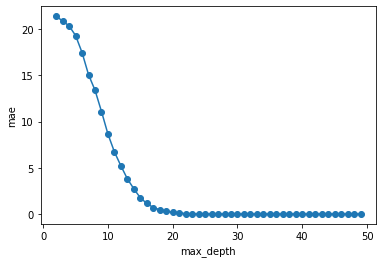

In [ ]:
# Compute the max 
mae = []
from sklearn.metrics import mean_absolute_error
for i in range(2, 50):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(X_train, y_train)
    pred_values = regressor.predict(X_train)
    maev = mean_absolute_error(y_train,pred_values)
    mae.append(maev)
    
# Plot mae   
plt.plot(range(2,50), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

In [ ]:
regressor = DecisionTreeRegressor(criterion='mae', max_depth=18, random_state=0)


In [ ]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

array([  3. ,  13.5,  12. ,   8. ,   2. ,  19. ,  13. ,  12. ,   6. ,
        19. ,   6.5,  12. ,  25. ,  12. ,  30. ,  12. ,  76. ,  22. ,
       202. ,  30. ,  22. ,  35.5,  30. ,   6. ,  17.5,  20. ,  14. ,
        30. ,   6.5,  17.5,  17.5,   0.5,  14. ,  17.5,  25. ,  25. ,
        14. ,  29. ,  22. ,  17. ,  25. ,  17.5,  22. ,   7. ,   7. ,
        22. ,  14. ,  13.5,   7. ,  14. ,  14. ,   7. ,   7. ,   6.5,
        22. ,  13.5,   2.5,   7. ,  13. ,   2. ,  40. ,  12. ,  21. ,
        82. , 202. , 202. ,  62. ,  19. ,  30. , 202. , 112. ,  22. ,
        21. ,  19. ,  82. , 202. , 202. , 353. ,  19. ,   3. ,  17.5,
        13. ,  13. ,   7. ,  25. ,  17. ,  14. ,  14. ,  25. ,  20. ,
       221. ,   7. ,  14. ,   8. ,  29. ,  26. ,  17. ,  17.5,  17.5,
        12. ,   8. ,   7. ,  17. ,  17.5,  22. ,  19. ,   3. ,   6. ,
        13. ,  18. ,  12. ,  19. ,  30. ,  12.5,   6. ,  19. ,  30. ,
        12.5,  19. , 202. ,  24.5,  22. ,  76. ,  30. ,  30. , 305.5,
        17.5,  22. ,

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([  3,  14,  12,   8,   2,  19,  13,  12,   6,  19,   6,  12,  25,
        12,  30,  12,  76,  22, 202,  30,  22,  36,  30,   6,  18,  20,
        14,  30,   6,  18,  18,   0,  14,  18,  25,  25,  14,  29,  22,
        17,  25,  18,  22,   7,   7,  22,  14,  14,   7,  14,  14,   7,
         7,   6,  22,  14,   2,   7,  13,   2,  40,  12,  21,  82, 202,
       202,  62,  19,  30, 202, 112,  22,  21,  19,  82, 202, 202, 353,
        19,   3,  18,  13,  13,   7,  25,  17,  14,  14,  25,  20, 221,
         7,  14,   8,  29,  26,  17,  18,  18,  12,   8,   7,  17,  18,
        22,  19,   3,   6,  13,  18,  12,  19,  30,  12,   6,  19,  30,
        12,  19, 202,  24,  22,  76,  30,  30, 306,  18,  22,  24,  17,
        12,  36,  30,  18,  17,  25,  14,   7,  18,   7,  22,   7,   7,
        29,  14,  29,  29,  17,   7,   7,  14,  25,  24,   7,  14,  14,
         7,   6,   7,   8,   5,  12,  12,   9,  13,  19,  12,  19,   2,
        12,  36,   0,  12,   4,   2,   3,  22,  20,  24,  12,   

In [ ]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('result2.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result2.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,3
1,sj,2008,19,14
2,sj,2008,20,12
3,sj,2008,21,8
4,sj,2008,22,2


El resultado que arroja este modelo es de MAE = 36.57, este modelo ha empeorado claramente al anterior. Vamos a probar otros modelos, y si los resultados siguen siendo malos entonces tenemos que replantearnos la selección de características que hemos hecho.

### RANDOM FOREST

Vamos a intentarlo con el algoritmo Random Forest, un algoritmo muy popular para este tipo de predicciones que se suele utiizar como algoritmo base.

Para parametrizar el algoritmo vamos a crear un dataset dummy, utilizamos el de training para dividirlo a su vez en un train2 y un test2 y así probar el número de estimadores para nuestro random forest. Es importante que el algoritmo sea profundo, pero si es demasiado profundo este puede tender al sobreaprendizaje y después no funcionar bien con el conjunto de test.

In [ ]:
X_train2['total_cases'] = train['total_cases']
X_train2

,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,station_precip_mm,station_avg_temp_c,precipitation_amt_mm,total_cases
0,0.056091,0.381614,0.029450,0.430091,0.031797,4
1,0.031446,0.479668,0.015829,0.565350,0.058423,5
2,0.045749,0.594415,0.076201,0.565350,0.088428,4
3,0.024365,0.552387,0.007362,0.645897,0.039324,3
4,0.021385,0.555396,0.010676,0.802432,0.019252,6
...,...,...,...,...,...,...
1451,0.078878,0.758854,0.049696,0.769504,0.141577,5
1452,0.363015,0.828282,0.067366,0.641844,0.221377,8
1453,0.088694,0.893932,0.013620,0.319149,0.150896,1
1454,0.109255,0.903240,0.029450,0.429078,0.152765,1


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cv = TimeSeriesSplit() #

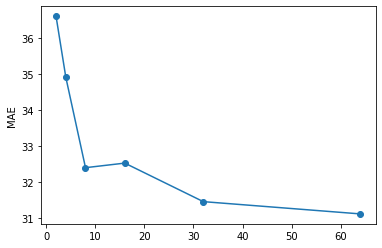

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64]#, 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators, 
                  criterion='mae', random_state=0)
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = X_train2.loc[train_fold]
      f_test = X_train2.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])
      y_pred = regressor.predict(X = f_test.drop(['total_cases'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['total_cases'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 


In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 64, MAE =  31.12)


Elegimos el número que minimiza el error

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='mae', 
                                   random_state=0)
# fit and predict

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred

array([ 28.75     ,  29.71875  ,  21.171875 ,  44.34375  ,  32.5      ,
        51.59375  ,  13.3828125,  16.84375  ,  34.125    ,  37.7578125,
        17.7265625,  35.65625  ,  26.40625  ,  23.453125 ,  64.5625   ,
        30.1875   , 100.25     ,  34.40625  , 109.625    ,  54.3125   ,
        37.15625  ,  62.875    ,  29.8125   ,  34.96875  ,  49.5859375,
        24.8359375,  15.203125 ,  58.328125 ,  13.328125 ,  63.46875  ,
        52.       ,  11.859375 ,  20.125    ,  64.796875 ,  17.34375  ,
        17.34375  ,  17.953125 ,  29.703125 ,  25.1328125,  19.96875  ,
        35.046875 ,  22.046875 ,  13.171875 ,  13.0625   ,  17.625    ,
        17.390625 ,  21.296875 ,  16.921875 ,  13.796875 ,  31.015625 ,
        28.984375 ,  17.890625 ,  22.875    ,  24.234375 ,  30.5546875,
        53.09375  ,  15.046875 ,  21.546875 ,  54.046875 ,  12.03125  ,
        13.5625   ,  32.6875   ,  67.71875  ,  79.140625 , 112.171875 ,
       121.515625 ,  98.609375 ,  46.375    ,  62.5      , 113.7

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([ 29,  30,  21,  44,  32,  52,  13,  17,  34,  38,  18,  36,  26,
        23,  65,  30, 100,  34, 110,  54,  37,  63,  30,  35,  50,  25,
        15,  58,  13,  63,  52,  12,  20,  65,  17,  17,  18,  30,  25,
        20,  35,  22,  13,  13,  18,  17,  21,  17,  14,  31,  29,  18,
        23,  24,  31,  53,  15,  22,  54,  12,  14,  33,  68,  79, 112,
       122,  99,  46,  62, 114,  56,  61,  46,  23, 102, 114, 108,  27,
        70,  19,  31,  33,  10,  13,  38,  43,  23,  23,  30,  22,  66,
        19,  20,  15,  21,  33,  35,  26,  41,  15,  19,  15,  20,  62,
        32,  31,  15,  29,  30,  37,  26,  16,  44,  20,  36,  46,  30,
        13,  19,  99,  32,  45, 145,  41,  44,  68,  53,  34,  34,  51,
        82,  69,  58,  21,  38,  19,  28,  10,  27,  14,  30,  18,  17,
        27,  21,  35,  26,  17,  24,  14,  30,  18,  22,  16,  12,  20,
        21,  23,  18,  41,  22,  23,  18,  23,  29,  86,  22,  58,   6,
        29,  37,  27,  18,  71,   6,  12,  26,  30,  30,  22,  1

In [ ]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('result3.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result3.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,29
1,sj,2008,19,30
2,sj,2008,20,21
3,sj,2008,21,44
4,sj,2008,22,32


El resultado de esta entrega es 32.59, ha mejorado notablemente con respecto al árbol de decisión, pero todavía está por debajo de la regresión lineal. Probablemente sea mejor idea volver al preproceso de los datos y la selección de características antes que seguir probando modelos, puesto que si el modelo más sencillo nos ha dado la mejor puntuación, el problema está en la entrada de datos al modelo.

 # Nueva selección de características

Vamos a probar a reducir alguna de las características que habiamos elegido al principio y que cuando hicimos el modelo de árbol de decisión vimos que parecia tener menos importancia.

In [ ]:
selected_features = ['reanalysis_relative_humidity_percent',	'station_avg_temp_c', 	'precipitation_amt_mm','reanalysis_avg_temp_k']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[selected_features])
X_test = scaler.transform(test[selected_features])
y_train = train['total_cases']

In [ ]:
X_train2 = pd.DataFrame(X_train, columns = ['reanalysis_relative_humidity_percent',	'station_avg_temp_c', 	'precipitation_amt_mm','reanalysis_avg_temp_k'])

## Random Forest

Vamos a probar con un Random Forest, como algoritmo base.

In [1]:
X_train2['total_cases'] = train['total_cases']
X_train2

NameError: ignored

Buscamos la mejor parametrización

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cv = TimeSeriesSplit() #

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64]#, 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators, 
                  criterion='mae', random_state=0)
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = X_train2.loc[train_fold]
      f_test = X_train2.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])
      y_pred = regressor.predict(X = f_test.drop(['total_cases'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['total_cases'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='mae', 
                                   random_state=0)
# fit and predict

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('result5.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result5.csv')

output.head()

En este caso, el resultado ha sido de 32.29, lo cual es una mejora muy pequeña respecto al anterior intento con Random Forest, con la selección de características inicial (fue de 32.59) pero al menos tenemos la pista de que estas caraterísticas si mejoran el modelo, aunque no demasiado, y sigue por encima de la regresión lineal con las características iniciales.

Vamos a probar a añadir algunas características a las iniciales, aumentando la complejidad del modelo. De la selección de características inicial con DBSCAN nos habíamos dejado un grupo sin representar, vamos añadir dos características de su representación, y ver que pasa.

In [ ]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c','reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent',	'precipitation_amt_mm']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[selected_features])
X_test = scaler.transform(test[selected_features])
y_train = train['total_cases']


In [ ]:
X_train2 = pd.DataFrame(X_train, columns = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c','reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent',	'precipitation_amt_mm'])
X_train2['total_cases'] = train['total_cases']
X_train2

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cv = TimeSeriesSplit() #

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256]#, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators, 
                  criterion='mae', random_state=0)
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = X_train2.loc[train_fold]
      f_test = X_train2.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['total_cases'], axis=1), 
                           y = f_train['total_cases'])
      y_pred = regressor.predict(X = f_test.drop(['total_cases'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['total_cases'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='mae', 
                                   random_state=0)
# fit and predict

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('result8.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result8.csv')

output.head()

28.8822 es el resultado para este último intento, y ahora si que entendemos que es una mejora importante. Lo cual nos indica que vamos por el buen camino, aunque estemos aplicando una estrategia un poco de ensayo y error a la hora de elegir características. Como la mejora ha sido importante, vamos a probar otro algortimo.

## KNN

Con la misma selección de características que antes, vamos a probar con un algoritmo KNN a ver si somos capaces de mejorar la puntuación que nos ha dado el Random Forest. Este es otro de los algoritmos de aprendizaje supervisado vistos en clase y vale la pena probar si es capaz de mejorar el rendimiento del Random Forest.

Para ello, primero vamos a buscar la mejor parametrización. De modo que usamos la división de nuestro dataset dummy, y calculamos cuál es el número de neighbors que minimiza el MAE.

Min Value uniform : 21.583916706030543 (18)
Min Value distance : 21.629646357697894 (26)


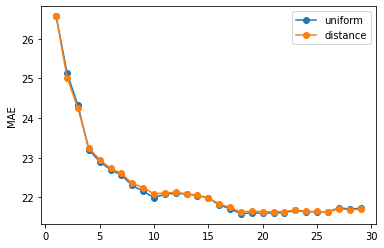

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) ## dividimos con el método kfold

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = X_train2.loc[train_fold]
          f_test = X_train2.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                               y = f_train['total_cases'])
          y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['total_cases'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

Vamos que la mejor combinación es el método 'uniform' con 18 neighbors.

In [ ]:
# constructor
n_neighbors = 18
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
y_pred


array([16.06422464, 29.09849813, 17.84842737, 43.72066559, 12.50149809,
       66.75753616, 20.80581921, 27.94519229, 32.22850646, 23.19146575,
       36.94749772, 47.16736666, 24.38182153, 43.177556  , 40.29494208,
       36.4006634 , 38.5198433 , 56.77813499, 55.42413055, 45.80262508,
       55.30690606, 32.32315044, 53.85670887, 48.0633905 , 26.75663555,
       24.43908695, 27.82632872, 27.52088702, 31.80060043, 33.41425113,
       27.18006139, 11.57685056, 19.19914941, 46.31912178, 19.40192789,
       19.40192789, 18.31102543, 31.58708855, 28.04366289, 32.39056442,
       20.24162265, 19.41270516, 10.04029356, 17.54907838, 15.23723491,
       11.1608789 , 12.749815  , 12.05805144, 10.42680761, 20.60856175,
       10.9183527 , 18.37880892, 33.94438707, 22.00195624, 18.46353944,
       40.45607609, 46.04737408, 15.67632546, 52.54642675, 48.55574501,
       39.38079607, 56.56452948, 30.46283915, 41.6764645 , 28.84140219,
       35.79148504, 41.25274292, 29.63615606, 46.35773635, 42.95

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('result9.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result9.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,16
1,sj,2008,19,29
2,sj,2008,20,18
3,sj,2008,21,44
4,sj,2008,22,13


El resultado es 27.45. Seguimos mejorando el modelo, el metodo KNN ha resultado ser más efectivo con las mismas características.


Probamos a buscar nuevas posibles características. Vamos a ver la correlación con total_cases

In [ ]:
train.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases', 'city_bin'],
      dtype='object')

Calculamos la correlación de pearson entre las variables del dataset y las etiquetas. Así, vamos a ver si nos estamos dejando fuera alguna variable que sea bastante explicativa.

In [ ]:
import numpy as np
from scipy.stats.stats import pearsonr 
corr =[pearsonr(train['ndvi_se'],train['total_cases'])[0],pearsonr(train['reanalysis_tdtr_k'],train['total_cases'])[0],
       pearsonr(train['reanalysis_tdtr_k'],train['total_cases'])[0],pearsonr(train['reanalysis_dew_point_temp_k'],train['total_cases'])[0],
       pearsonr(train['reanalysis_max_air_temp_k'],train['total_cases'])[0],pearsonr(train['reanalysis_relative_humidity_percent'],train['total_cases'])[0],
       pearsonr(train['reanalysis_specific_humidity_g_per_kg'],train['total_cases'])[0],pearsonr(train['reanalysis_sat_precip_amt_mm'],train['total_cases'])[0],
       pearsonr(train['station_diur_temp_rng_c'],train['total_cases'])[0],pearsonr(train['precipitation_amt_mm'],train['total_cases'])[0],
       pearsonr(train['station_precip_mm'],train['total_cases'])[0],pearsonr(train['reanalysis_precip_amt_kg_per_m2'],train['total_cases'])[0],
       pearsonr(train['station_avg_temp_c'],train['total_cases'])[0],pearsonr(train['reanalysis_min_air_temp_k'],train['total_cases'])[0]]

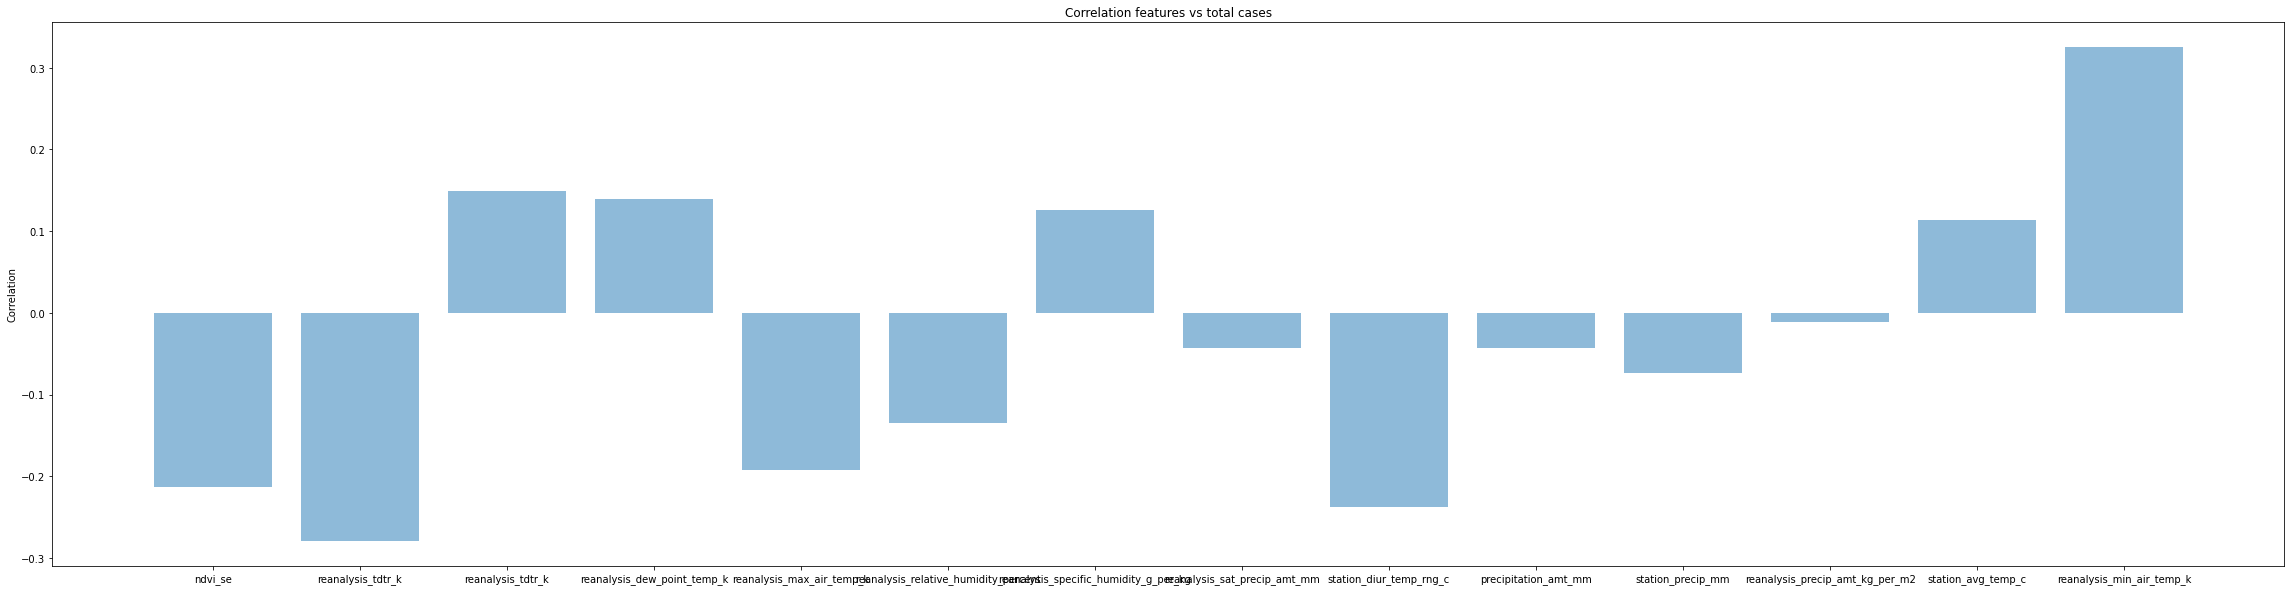

In [ ]:
features = ('ndvi_se','reanalysis_tdtr_k','reanalysis_tdtr_k','reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k','reanalysis_relative_humidity_percent',
'reanalysis_specific_humidity_g_per_kg','reanalysis_sat_precip_amt_mm','station_diur_temp_rng_c','precipitation_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',
'station_avg_temp_c','reanalysis_min_air_temp_k')
y_pos = np.arange(len(features))
plt.rcParams["figure.figsize"] = (40,10)
plt.bar(y_pos,corr,align='center',alpha=0.5)
plt.xticks(y_pos,features)
plt.ylabel('Correlation')
plt.title('Correlation features vs total cases')
plt.show()

Parece que ''reanalysis_min_air_temp_k'', 'reanalysis_tdtr_k', correlacionan bastante bien y no las habíamos incluido en el análisis. Así mismo, alguna de las utilizadas no parecen buenas predictoras.


Probemos entonces a hacer una nueva selección y a volver a aplicar el algoritmo KNN

In [ ]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c','reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent',	
                 'precipitation_amt_mm','reanalysis_tdtr_k','reanalysis_min_air_temp_k','station_diur_temp_rng_c']

Una vez seleccionadas las nuevas características, 9 en total, vamos a aplicar el algoritmo KNN del mismo modo que en la anterior ocasión.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[selected_features])
X_test = scaler.transform(test[selected_features])
y_train = train['total_cases']

In [ ]:
X_train2 = pd.DataFrame(X_train, columns = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c','reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent',	
                 'precipitation_amt_mm','reanalysis_tdtr_k','reanalysis_min_air_temp_k','station_diur_temp_rng_c'])
X_train2['total_cases'] = train['total_cases']
X_train2

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,precipitation_amt_mm,reanalysis_tdtr_k,reanalysis_min_air_temp_k,station_diur_temp_rng_c,total_cases
0,0.262659,0.314680,0.430091,0.486239,0.056091,0.381614,0.031797,0.086660,0.692308,0.210393,4
1,0.418164,0.489213,0.565350,0.688073,0.031446,0.479668,0.058423,0.069133,0.730769,0.163498,5
2,0.586900,0.657583,0.565350,0.743119,0.045749,0.594415,0.088428,0.064265,0.800000,0.173638,4
3,0.566808,0.643471,0.645897,0.788991,0.024365,0.552387,0.039324,0.073028,0.776923,0.198986,3
4,0.628226,0.701541,0.802432,0.844037,0.021385,0.555396,0.019252,0.112950,0.815385,0.429658,6
...,...,...,...,...,...,...,...,...,...,...,...
1451,0.774093,0.815572,0.769504,0.706422,0.078878,0.758854,0.141577,0.575463,0.584615,0.656950,5
1452,0.726560,0.773236,0.641844,0.642202,0.363015,0.828282,0.221377,0.416748,0.384615,0.529785,8
1453,0.605194,0.665207,0.319149,0.412844,0.088694,0.893932,0.150896,0.418695,0.423077,0.210393,1
1454,0.583143,0.645093,0.429078,0.577982,0.109255,0.903240,0.152765,0.444012,0.384615,0.373046,1


Min Value uniform : 20.931001742869704 (29)
Min Value distance : 20.93073151657837 (29)


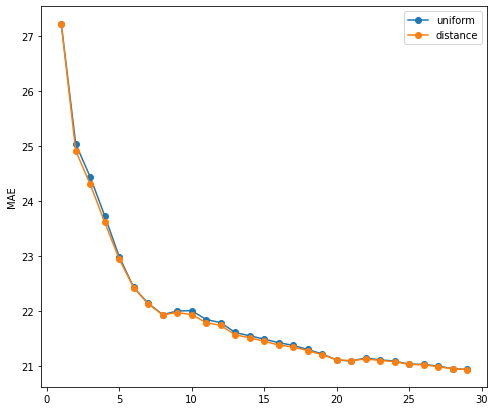

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) 


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = X_train2.loc[train_fold]
          f_test = X_train2.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                               y = f_train['total_cases'])
          y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['total_cases'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   plt.rcParams["figure.figsize"] = (8,7)
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

In [ ]:
# constructor
n_neighbors = 29
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
y_pred


array([17.11122279, 25.31849257, 15.61437187, 35.33316735, 13.87171724,
       33.60885378, 29.54937846, 43.00383885, 30.14403709, 40.84092078,
       37.78998724, 33.32510379, 24.11500911, 33.63131445, 47.66275296,
       38.78364318, 49.18466556, 57.91732742, 57.8970506 , 48.92236623,
       54.88253639, 33.31269932, 37.56945624, 40.47318409, 38.15448335,
       33.22835501, 38.9945977 , 26.50009133, 27.05745056, 23.52881655,
       35.92006452, 15.92312441, 13.3204934 , 28.24102889, 17.33006572,
       17.33006572, 16.34325146, 24.57734146, 24.25269374, 27.72013711,
       19.09590535, 16.67754521, 11.33087922, 14.95888654, 17.50395578,
       12.31428298, 14.35491302, 13.79301111, 17.632851  , 11.21044602,
       17.14837256, 18.68591394, 23.75827041, 16.01284176, 27.96314642,
       40.27290993, 38.98268103, 15.00244244, 56.47403345, 40.66231154,
       57.70259647, 47.32253792, 26.03979952, 40.5895991 , 41.20045855,
       39.54028694, 36.9071358 , 33.03379977, 51.96970683, 37.63

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})


from google.colab import files

with open('result13.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result13.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,17
1,sj,2008,19,25
2,sj,2008,20,16
3,sj,2008,21,35
4,sj,2008,22,14


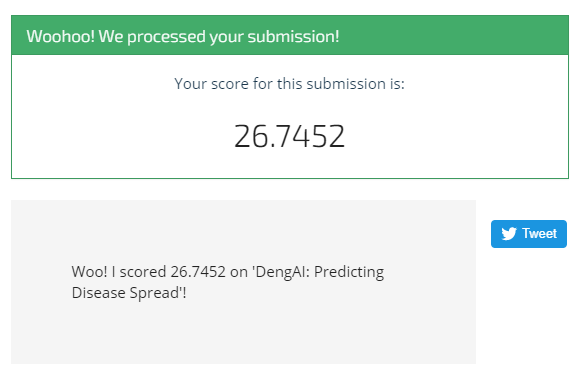

Nuevamente nos encontramos ante una sustancial mejora del modelo, obteniendo ahora un MAE ya bastante bueno. 26.74